Import Libraries    

In [576]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from datetime import datetime
from sklearn import model_selection, preprocessing

# python core library for machine learning and data science
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

RANDOM_STATE = 42

In [577]:
df_weekly_items_sales = pd.read_csv('./datasets/weekly_items_sales.csv', index_col=0)

/Users/artur/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [578]:
df_weekly_items_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8354260 entries, 0 to 8354259
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   id                  object 
 1   item                object 
 2   category            object 
 3   department          object 
 4   store               object 
 5   store_code          object 
 6   region              object 
 7   date                object 
 8   quantity            int64  
 9   event               int64  
 10  sell_price          float64
 11  sell_price_imputed  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 828.6+ MB


In [579]:
# specify the format since otherwise it might give some problems
df_weekly_items_sales["date"] = pd.to_datetime(df_weekly_items_sales["date"], format = "%Y-%m-%d")
df_weekly_items_sales.drop('sell_price', axis=1, inplace=True)
df_weekly_items_sales.rename(columns={'sell_price_imputed': 'sell_price'}, inplace=True)

In [580]:
df_weekly_items_sales.isnull().sum()

id            0
item          0
category      0
department    0
store         0
store_code    0
region        0
date          0
quantity      0
event         0
sell_price    0
dtype: int64

In [581]:
df_weekly_items_sales.head()

,id,item,category,department,store,store_code,region,date,quantity,event,sell_price
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-30,0,0,12.7414
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-06,0,1,12.7414
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-13,0,0,12.7414
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-20,0,0,12.7414
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-27,0,0,12.7414


In [582]:
df_weekly_items_sales.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
quantity,8354260.0,7.863702,23.680201,0.000,0.0000,2.000,7.000,3976.00
event,8354260.0,0.094891,0.293064,0.000,0.0000,0.000,0.000,1.00
sell_price,8354260.0,5.562442,4.547930,0.012,2.6201,4.176,7.176,134.15


In [583]:
df_categorical_col = df_weekly_items_sales.describe(exclude=np.number).T
df_categorical_col['total'] = df_categorical_col['unique'] * df_categorical_col['freq']
df_categorical_col

/var/folders/pt/rrqbl2q559x5dkq3bsgd3gzh0000gn/T/ipykernel_4467/2085997088.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_categorical_col = df_weekly_items_sales.describe(exclude=np.number).T


,count,unique,top,freq,first,last,total
id,8354260,30490,ACCESORIES_1_001_BOS_1,274,NaT,NaT,8354260
item,8354260,3049,ACCESORIES_1_001,2740,NaT,NaT,8354260
category,8354260,3,SUPERMARKET,3937380,NaT,NaT,11812140
department,8354260,7,SUPERMARKET_3,2255020,NaT,NaT,15785140
store,8354260,10,South_End,835426,NaT,NaT,8354260
store_code,8354260,10,BOS_1,835426,NaT,NaT,8354260
region,8354260,3,New York,3341704,NaT,NaT,10025112
date,8354260,274,2011-01-30 00:00:00,30490,2011-01-30,2016-04-24,8354260


In [584]:
df_weekly_items_sales[df_weekly_items_sales['id'] == 'ACCESORIES_1_001_NYC_1'].head()

,id,item,category,department,store,store_code,region,date,quantity,event,sell_price
822,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,2011-01-30,0,0,12.7414
823,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,2011-02-06,0,1,12.7414
824,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,2011-02-13,0,0,12.7414
825,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,2011-02-20,0,0,12.7414
826,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,2011-02-27,0,0,12.7414


In [585]:
df_weekly_items_sales

,id,item,category,department,store,store_code,region,date,quantity,event,sell_price
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-30,0,0,12.7414
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-06,0,1,12.7414
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-13,0,0,12.7414
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-20,0,0,12.7414
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-27,0,0,12.7414
...,...,...,...,...,...,...,...,...,...,...,...
8354255,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-03-27,17,1,1.2000
8354256,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-03,22,0,1.2000
8354257,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-10,8,0,1.2000
8354258,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-17,0,0,1.2000


In [586]:
df_weekly_items_sales["revenue"] = df_weekly_items_sales["quantity"] * df_weekly_items_sales["sell_price"]

In [587]:
df_weekly_items_sales["event_quantity"] = df_weekly_items_sales["quantity"] * df_weekly_items_sales["event"]

In [588]:
df_weekly_items_sales

,id,item,category,department,store,store_code,region,date,quantity,event,sell_price,revenue,event_quantity
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-30,0,0,12.7414,0.0,0
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-06,0,1,12.7414,0.0,0
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-13,0,0,12.7414,0.0,0
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-20,0,0,12.7414,0.0,0
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-27,0,0,12.7414,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354255,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-03-27,17,1,1.2000,20.4,17
8354256,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-03,22,0,1.2000,26.4,0
8354257,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-10,8,0,1.2000,9.6,0
8354258,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-17,0,0,1.2000,0.0,0


In [589]:
df_weekly_items_sales['department'].unique()

array(['ACCESORIES_1', 'ACCESORIES_2', 'HOME_&_GARDEN_1',
       'HOME_&_GARDEN_2', 'SUPERMARKET_1', 'SUPERMARKET_2',
       'SUPERMARKET_3'], dtype=object)

In [590]:
# # set index
df_items_sales = df_weekly_items_sales.set_index("item")

# # groupby shop_id and item_id
df_items_sales = df_items_sales.groupby(['item']).agg({
  'quantity':np.sum, 
  "sell_price":np.mean, 
  "revenue":np.sum, 
  "event_quantity": np.sum,
  "category": lambda serie: serie.unique(),
  })

# # convert to dataframe and save the full dataframe
df_items_sales.reset_index(inplace = True)
df_items_sales

,item,quantity,sell_price,revenue,event_quantity,category
0,ACCESORIES_1_001,4093,11.470706,45037.9230,415,ACCESORIES
1,ACCESORIES_1_002,5059,5.276746,26708.0758,447,ACCESORIES
2,ACCESORIES_1_003,1435,3.947629,5656.3437,146,ACCESORIES
3,ACCESORIES_1_004,39175,5.977661,235347.8358,3665,ACCESORIES
4,ACCESORIES_1_005,14621,3.838264,55670.1292,1311,ACCESORIES
...,...,...,...,...,...,...
3044,SUPERMARKET_3_823,15388,3.345153,50854.0440,1164,SUPERMARKET
3045,SUPERMARKET_3_824,8325,3.026768,25414.5600,672,SUPERMARKET
3046,SUPERMARKET_3_825,13526,4.933888,65787.5640,1136,SUPERMARKET
3047,SUPERMARKET_3_826,12188,1.535877,18719.7600,1135,SUPERMARKET


In [591]:
df_items_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3049 entries, 0 to 3048
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   item            3049 non-null   object 
 1   quantity        3049 non-null   int64  
 2   sell_price      3049 non-null   float64
 3   revenue         3049 non-null   float64
 4   event_quantity  3049 non-null   int64  
 5   category        3049 non-null   object 
dtypes: float64(2), int64(2), object(2)
memory usage: 143.0+ KB


In [592]:
# # set index
df_category_sales = df_weekly_items_sales.set_index("item")

# # groupby category
df_category_sales = df_category_sales.groupby('category').agg({'quantity':np.sum, "sell_price":np.mean, "revenue":np.sum})

# # convert to dataframe and save the full dataframe
df_category_sales.reset_index(inplace = True)
df_category_sales

,category,quantity,sell_price,revenue
0,ACCESORIES,6124800,7.392877,3.034657e+07
1,HOME_&_GARDEN,14480670,6.801597,6.993592e+07
2,SUPERMARKET,45089939,3.939902,1.306688e+08


In [593]:
COLS = ['quantity', 'sell_price', 'revenue']

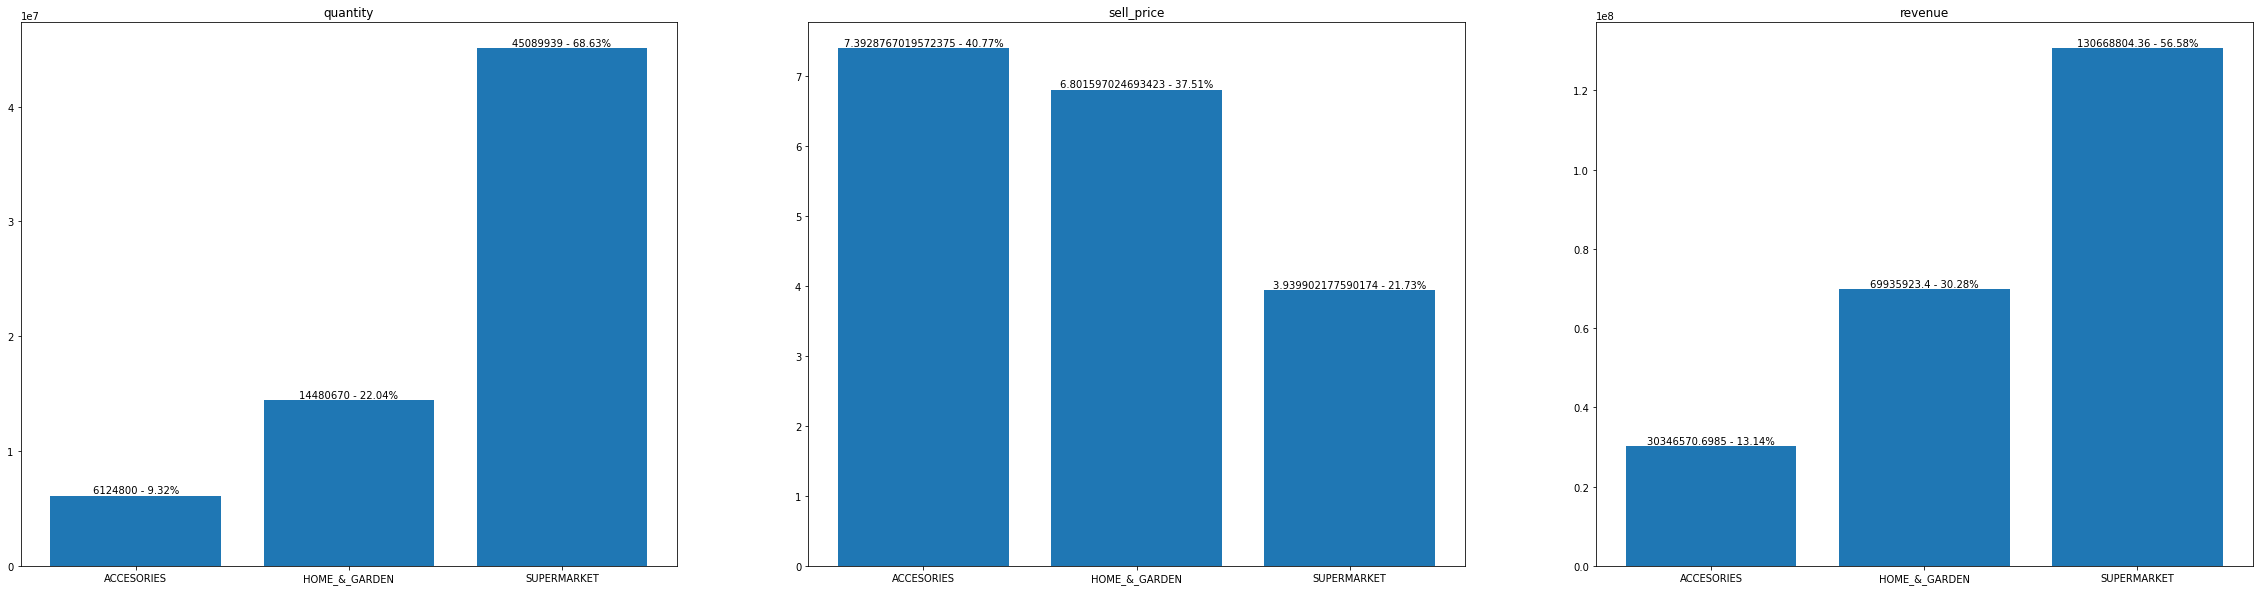

In [594]:
plt.figure(figsize = (40, 10))
for index, column in enumerate(COLS):
  plt.subplot(1,3, index + 1, title=column)
  # separete the data
  x = df_category_sales["category"].values
  y = df_category_sales[column].values
  y_pct = y/sum(y)

  # plot the data
  barplot = plt.bar(x, y)
  
  # add text to each column
  for rect, y_pct_ in zip(barplot, y_pct):
      y_pct_ = round(y_pct_*100, 2)
      height = rect.get_height()
      plt.text(
          rect.get_x() + rect.get_width()/2.0, 
          height, 
          f"{height} - {y_pct_}%", 
          ha = 'center', 
          va = "bottom"
      )
      

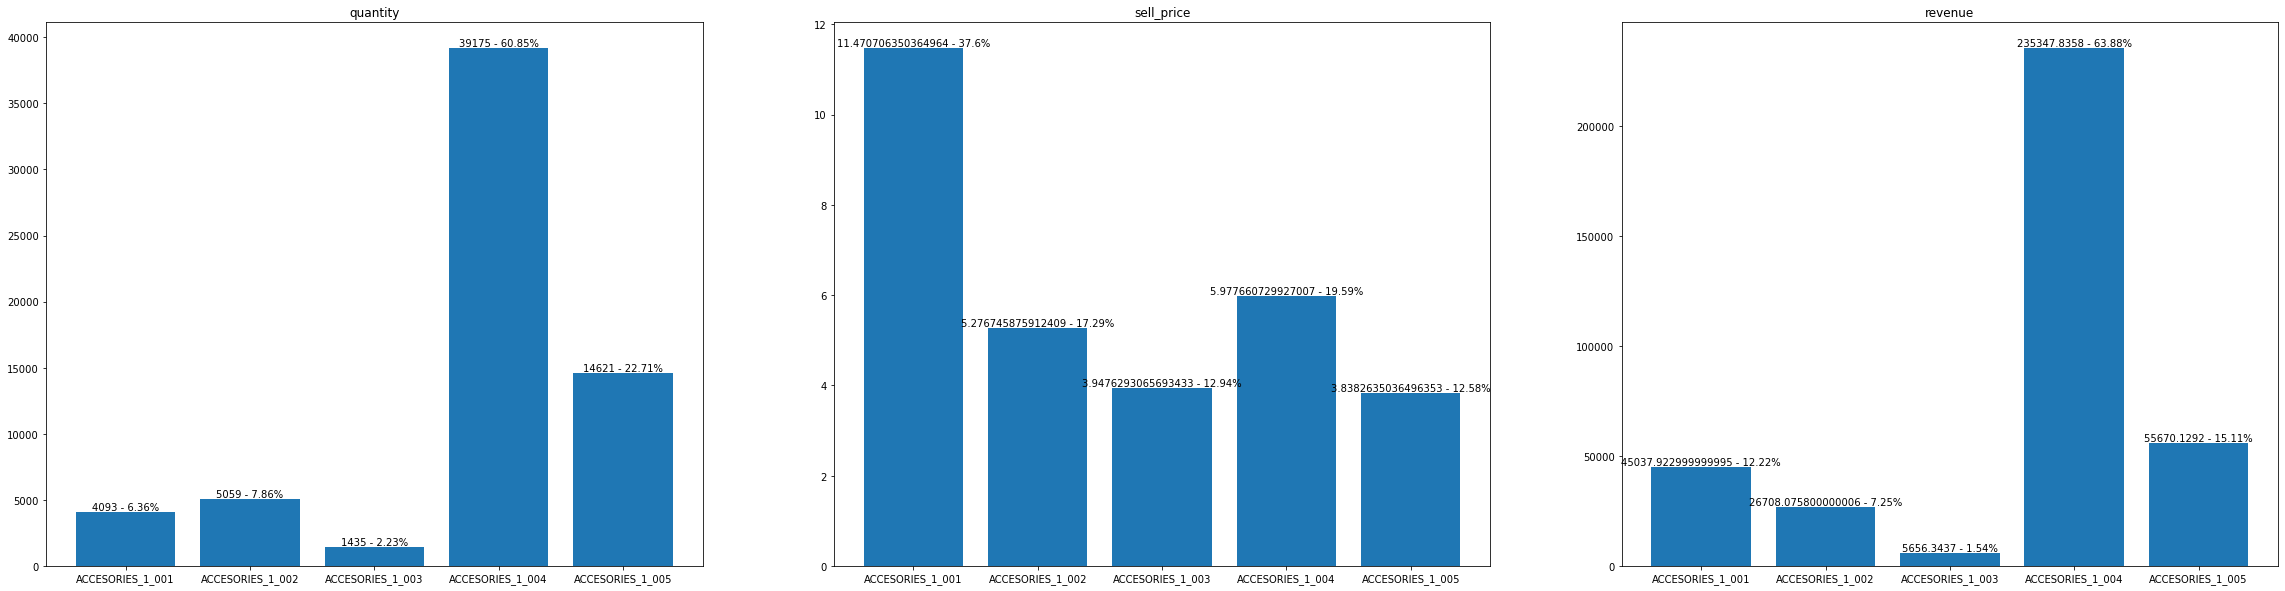

In [595]:
plt.figure(figsize = (40, 10))
for index, column in enumerate(COLS):
  plt.subplot(1,3, index + 1, title=column)
  df_items_sales.sort_values(column, ascending = True)
  df_items_sales_head = df_items_sales.head(5)
  # separete the data
  x = df_items_sales_head["item"].values
  y = df_items_sales_head[column].values
  y_pct = y/sum(y)

  # plot the data
  barplot = plt.bar(x, y)
  
  # add text to each column
  for rect, y_pct_ in zip(barplot, y_pct):
      y_pct_ = round(y_pct_*100, 2)
      height = rect.get_height()
      plt.text(
          rect.get_x() + rect.get_width()/2.0, 
          height, 
          f"{height} - {y_pct_}%", 
          ha = 'center', 
          va = "bottom"
      )

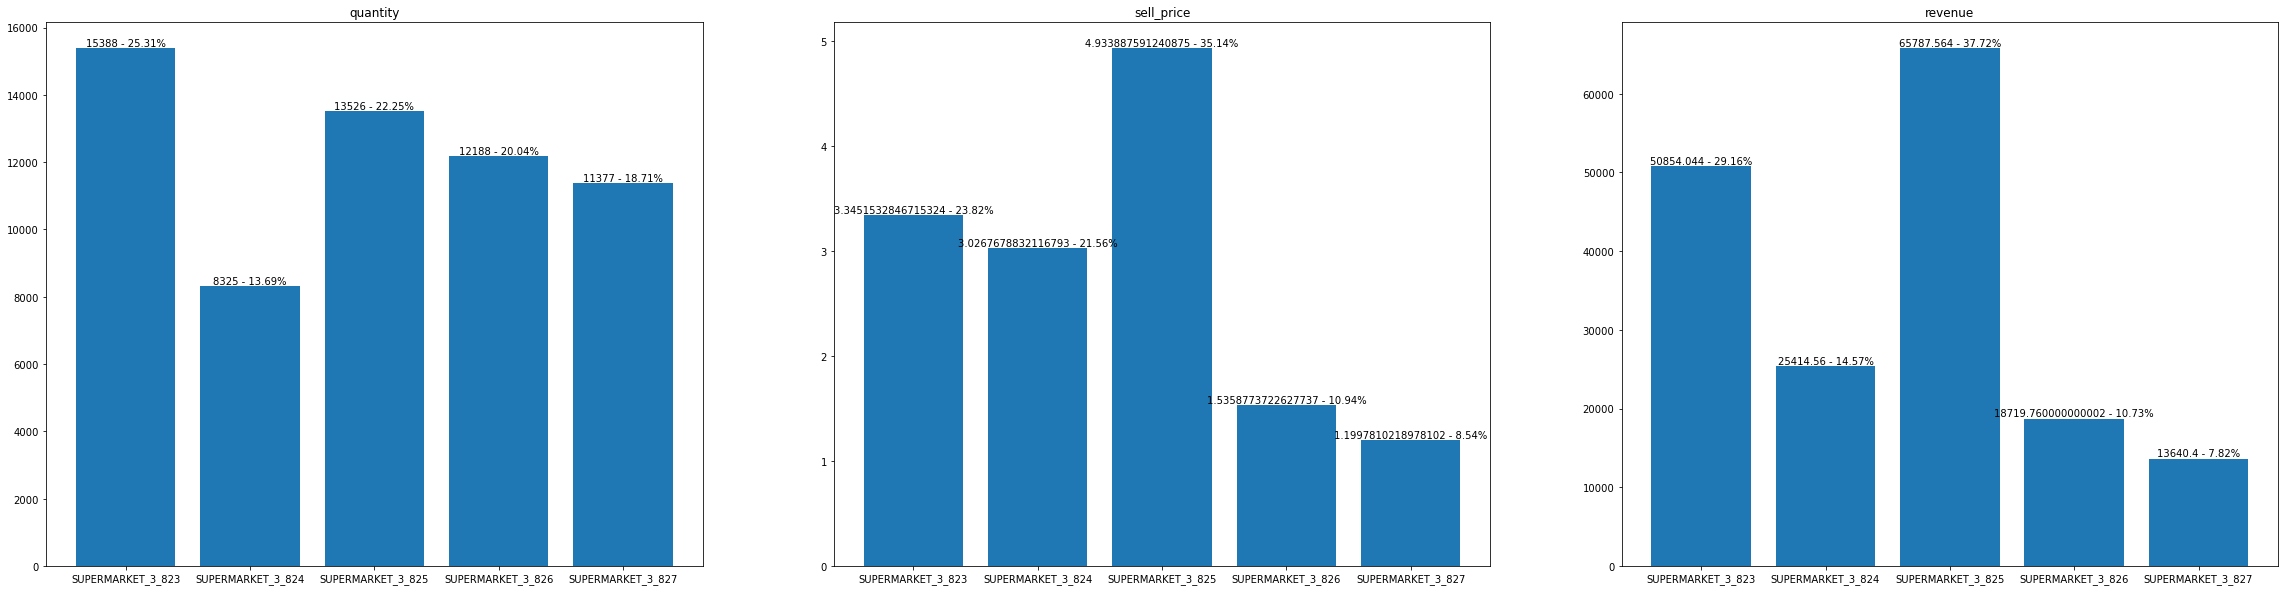

In [596]:
plt.figure(figsize = (40, 10))
for index, column in enumerate(COLS):
  plt.subplot(1,3, index + 1, title=column)
  df_items_sales.sort_values(column, ascending = True)
  df_items_sales_tail = df_items_sales.tail(5)
  # separete the data
  x = df_items_sales_tail["item"].values
  y = df_items_sales_tail[column].values
  y_pct = y/sum(y)

  # plot the data
  barplot = plt.bar(x, y)
  
  # add text to each column
  for rect, y_pct_ in zip(barplot, y_pct):
      y_pct_ = round(y_pct_*100, 2)
      height = rect.get_height()
      plt.text(
          rect.get_x() + rect.get_width()/2.0, 
          height, 
          f"{height} - {y_pct_}%", 
          ha = 'center', 
          va = "bottom"
      )

In [597]:
# Imputar los valores nulos                 ---> ffill, backfill
# Agrupar a nivel de item_id
# Tratar a los outliers
# Estandarizar                              ---> StandardScaler, MinMaxScaler
# Fittear nuestro modelo                    ---> KMeans

In [598]:
df_final = df_items_sales.set_index('item')[['quantity', 'sell_price', 'revenue', 'category', 'department', 'event_quantity']]
df_final

KeyError: "['department'] not in index"

In [ ]:
def OHE(col_name,dataframe):
  _dummy_dataset = pd.get_dummies(dataframe[col_name], prefix = col_name)
  dataframe = pd.concat([dataframe,_dummy_dataset], axis = 1)
  return dataframe.drop([col_name], axis =1)
  
df_final = OHE("category", df_final)
df_final

,quantity,sell_price,revenue,event_quantity,category_ACCESORIES,category_HOME_&_GARDEN,category_SUPERMARKET,department_ACCESORIES_1,department_ACCESORIES_2,department_HOME_&_GARDEN_1,department_HOME_&_GARDEN_2,department_SUPERMARKET_1,department_SUPERMARKET_2,department_SUPERMARKET_3
item,,,,,,,,,,,,,,
ACCESORIES_1_001,4093,11.470706,45037.9230,415,1,0,0,1,0,0,0,0,0,0
ACCESORIES_1_002,5059,5.276746,26708.0758,447,1,0,0,1,0,0,0,0,0,0
ACCESORIES_1_003,1435,3.947629,5656.3437,146,1,0,0,1,0,0,0,0,0,0
ACCESORIES_1_004,39175,5.977661,235347.8358,3665,1,0,0,1,0,0,0,0,0,0
ACCESORIES_1_005,14621,3.838264,55670.1292,1311,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_823,15388,3.345153,50854.0440,1164,0,0,1,0,0,0,0,0,0,1
SUPERMARKET_3_824,8325,3.026768,25414.5600,672,0,0,1,0,0,0,0,0,0,1
SUPERMARKET_3_825,13526,4.933888,65787.5640,1136,0,0,1,0,0,0,0,0,0,1


In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(df_final)
scaler.mean_

array([2.15465428e+04, 5.56244239e+00, 7.57465721e+04, 2.02532994e+03,
       1.85306658e-01, 3.43391276e-01, 4.71302066e-01, 1.36438176e-01,
       4.88684815e-02, 1.74483437e-01, 1.68907839e-01, 7.08428993e-02,
       1.30534602e-01, 2.69924565e-01])

In [ ]:
X_scaled = scaler.transform(df_final)
X_scaled

array([[-0.39447335,  1.30347904, -0.27124478, ..., -0.27612364,
        -0.38746874, -0.60804726],
       [-0.37264046, -0.06303026, -0.4331495 , ..., -0.27612364,
        -0.38746874, -0.60804726],
       [-0.4545477 , -0.35625947, -0.61909621, ..., -0.27612364,
        -0.38746874, -0.60804726],
       ...,
       [-0.18127497, -0.13867153, -0.08796639, ..., -0.27612364,
        -0.38746874,  1.644609  ],
       [-0.21151555, -0.8883393 , -0.50370906, ..., -0.27612364,
        -0.38746874,  1.644609  ],
       [-0.22984523, -0.96248876, -0.54857427, ..., -0.27612364,
        -0.38746874,  1.644609  ]])

In [ ]:
sse = {}

for k in range(2, 15):
    print(f"Fitting pipe with {k} clusters")
    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(X_scaled)
    sse[k] = clustering_model.inertia_


Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters


In [ ]:
sse

{2: 33207.12418577077,
 3: 25606.748291858294,
 4: 21779.35863063014,
 5: 18015.028672213528,
 6: 14490.676071024658,
 7: 11007.48012909918,
 8: 7641.557824819774,
 9: 6168.265935231316,
 10: 5389.895103763984,
 11: 4719.089560264149,
 12: 4320.236104209196,
 13: 3910.3755146450285,
 14: 3712.0607271442022}

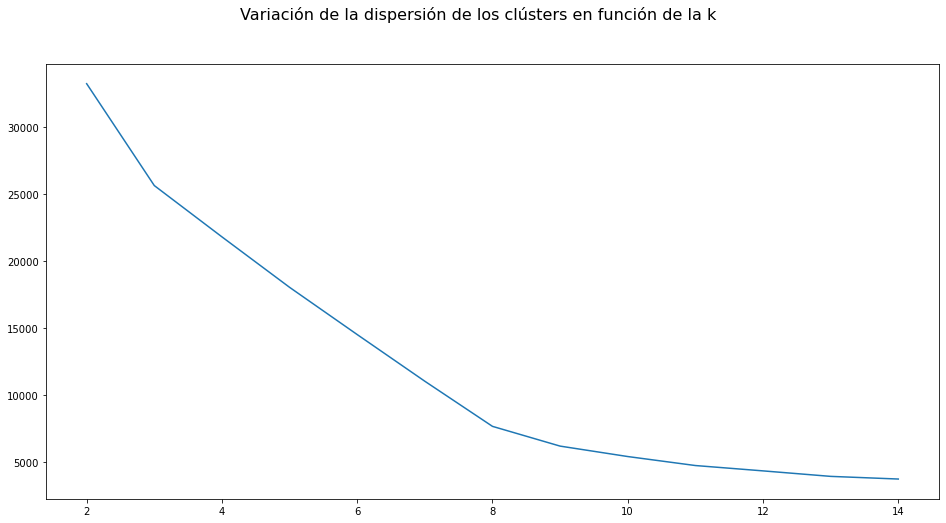

In [ ]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

In [ ]:
clustering_model = KMeans(n_clusters = 5)
clustering_model.fit(X_scaled)

KMeans(n_clusters=5)

In [ ]:
clustering_model.cluster_centers_

array([[ 3.27888125e-01, -4.45061750e-01,  1.86576852e-01,
         3.20661965e-01, -4.76923177e-01, -7.23171503e-01,
         1.05914186e+00, -3.97485450e-01, -2.26670047e-01,
        -4.59742029e-01, -4.50817026e-01,  5.34175664e-01,
        -3.87468742e-01,  1.17629932e+00],
       [-2.41974149e-01,  4.03829749e-01, -1.94639076e-01,
        -2.30839885e-01,  2.09677375e+00, -7.23171503e-01,
        -9.44160583e-01,  1.74752895e+00,  9.96545836e-01,
        -4.59742029e-01, -4.50817026e-01, -2.76123639e-01,
        -3.87468742e-01, -6.08047263e-01],
       [-3.56193756e-01,  3.52129224e-01, -3.54114088e-01,
        -3.40858701e-01, -4.76923177e-01,  1.38279785e+00,
        -9.44160583e-01, -3.97485450e-01, -2.26670047e-01,
        -4.59742029e-01,  2.21819484e+00, -2.76123639e-01,
        -3.87468742e-01, -6.08047263e-01],
       [-5.37038381e-02, -1.30591557e-01, -2.79393624e-03,
        -6.58198902e-02, -4.76923177e-01, -7.23171503e-01,
         1.05914186e+00, -3.97485450e-01, -2.

In [ ]:
labels = clustering_model.predict(X_scaled)
df_final["cluster"] = labels

In [ ]:
df_final

,quantity,sell_price,revenue,event_quantity,category_ACCESORIES,category_HOME_&_GARDEN,category_SUPERMARKET,department_ACCESORIES_1,department_ACCESORIES_2,department_HOME_&_GARDEN_1,department_HOME_&_GARDEN_2,department_SUPERMARKET_1,department_SUPERMARKET_2,department_SUPERMARKET_3,cluster
item,,,,,,,,,,,,,,,
ACCESORIES_1_001,4093,11.470706,45037.9230,415,1,0,0,1,0,0,0,0,0,0,1
ACCESORIES_1_002,5059,5.276746,26708.0758,447,1,0,0,1,0,0,0,0,0,0,1
ACCESORIES_1_003,1435,3.947629,5656.3437,146,1,0,0,1,0,0,0,0,0,0,1
ACCESORIES_1_004,39175,5.977661,235347.8358,3665,1,0,0,1,0,0,0,0,0,0,1
ACCESORIES_1_005,14621,3.838264,55670.1292,1311,1,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_823,15388,3.345153,50854.0440,1164,0,0,1,0,0,0,0,0,0,1,0
SUPERMARKET_3_824,8325,3.026768,25414.5600,672,0,0,1,0,0,0,0,0,0,1,0
SUPERMARKET_3_825,13526,4.933888,65787.5640,1136,0,0,1,0,0,0,0,0,0,1,0


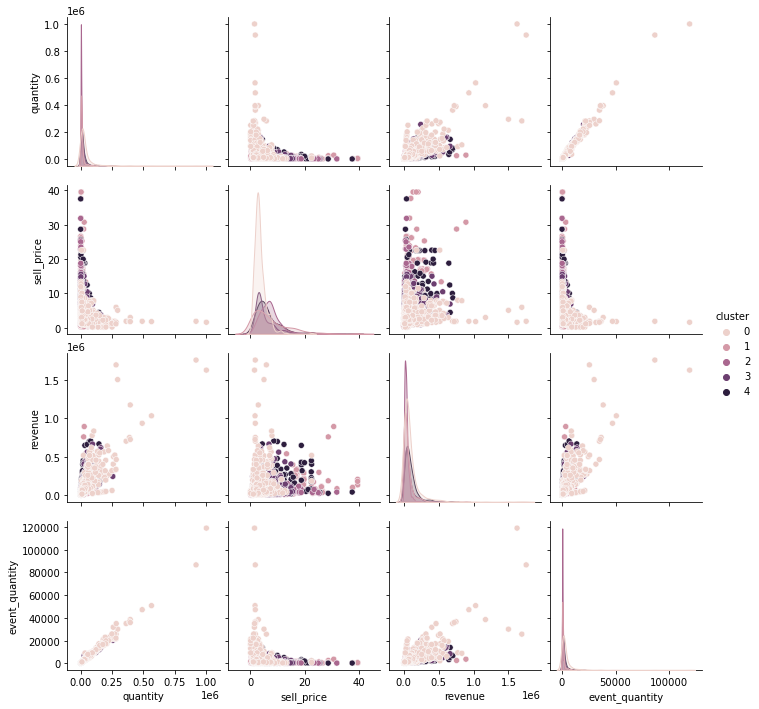

In [ ]:
sns.pairplot(df_final, vars = ['quantity', 'sell_price', 'revenue', 'event_quantity'], hue = 'cluster');

In [ ]:
selected_columns = [
  'quantity', 
  'sell_price', 
  'revenue', 
  'event_quantity', 
  'category_ACCESORIES',
  'category_HOME_&_GARDEN', 
  'category_SUPERMARKET'
]

In [ ]:
ficha_df = pd.DataFrame()

In [ ]:
for i, col in enumerate(selected_columns):
    resumen_data = df_final[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = ficha_df.append(resumen_data)

In [ ]:
ficha_df

cluster                                 0              1              2  \
quantity               mean  3.605401e+04   10840.353982    5786.687379   
                       std   6.761847e+04   16919.722104    4983.507365   
                       min   8.230000e+02     660.000000     568.000000   
                       25%   8.209500e+03    2483.000000    2386.500000   
                       50%   1.649900e+04    4829.000000    4245.000000   
                       75%   3.429500e+04   10994.000000    7542.500000   
                       max   1.002529e+06  122565.000000   36283.000000   
sell_price             mean  3.545116e+00       7.392877       7.158534   
                       std   2.155585e+00       6.881382       3.770209   
                       min   2.395226e-01       0.305900       0.975000   
                       25%   2.349109e+00       2.492134       4.734872   
                       50%   3.011961e+00       5.280100       6.837938   
                       75%   4.359004e+00      10.417890       8.713508   
                       max   2.256711e+01      39.447169      31.800265   
revenue                mean  9.686964e+04   53710.744599   35655.974005   
                       std   1.549722e+05   78961.903817   29234.182867   
                       min   2.465652e+03     558.879300    1920.750000   
                       25%   2.726694e+04   11556.675900   14631.912500   
                       50%   5.043130e+04   28121.413600   29902.062500   
                       75%   1.031840e+05   63475.832700   45935.856250   
                       max   1.754296e+06  890942.528000  225435.637500   
event_quantity         mean  3.428856e+03    1014.952212     533.403883   
                       std   6.792200e+03    1595.200522     466.953280   
                       min   9.500000e+01      45.000000      55.000000   
                       25%   7.610000e+02     225.000000     222.000000   
                       50%   1.526000e+03     457.000000     390.000000   
                       75%   3.194500e+03    1018.000000     672.500000   
                       max   1.190810e+05   11818.000000    3665.000000   
category_ACCESORIES    mean  0.000000e+00       1.000000       0.000000   
                       std   0.000000e+00       0.000000       0.000000   
                       min   0.000000e+00       1.000000       0.000000   
                       25%   0.000000e+00       1.000000       0.000000   
                       50%   0.000000e+00       1.000000       0.000000   
                       75%   0.000000e+00       1.000000       0.000000   
                       max   0.000000e+00       1.000000       0.000000   
category_HOME_&_GARDEN mean  0.000000e+00       0.000000       1.000000   
                       std   0.000000e+00       0.000000       0.000000   
                       min   0.000000e+00       0.000000       1.000000   
                       25%   0.000000e+00       0.000000       1.000000   
                       50%   0.000000e+00       0.000000       1.000000   
                       75%   0.000000e+00       0.000000       1.000000   
                       max   0.000000e+00       0.000000       1.000000   
category_SUPERMARKET   mean  1.000000e+00       0.000000       0.000000   
                       std   0.000000e+00       0.000000       0.000000   
                       min   1.000000e+00       0.000000       0.000000   
                       25%   1.000000e+00       0.000000       0.000000   
                       50%   1.000000e+00       0.000000       0.000000   
                       75%   1.000000e+00       0.000000       0.000000   
                       max   1.000000e+00       0.000000       0.000000   

cluster                                  3              4  
quantity               mean   19170.407035   21617.530075  
                       std    25552.422077   26602.760437  
                       min     1094.000000     855.000000  
         

In [ ]:
# generamos nuestro multiindex
out_index = [
    "Sales",
    "Sales",
    "Sales",
    "Event",
    "category",
    "category",
    "category"
]

inner_index = [
    "Quantity",
    "Price",
    "Revenue",
    "Quantity",
    "ACCESORIES",
    'HOME_&_GARDEN',
    'SUPERMARKET'
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))
        
new_multi_index

[('Sales', 'Quantity', 'Media'),
 ('Sales', 'Quantity', 'Desviación'),
 ('Sales', 'Quantity', 'Mínimo'),
 ('Sales', 'Quantity', 'Perc. 25'),
 ('Sales', 'Quantity', 'Perc. 50'),
 ('Sales', 'Quantity', 'Perc. 75'),
 ('Sales', 'Quantity', 'Máximo'),
 ('Sales', 'Price', 'Media'),
 ('Sales', 'Price', 'Desviación'),
 ('Sales', 'Price', 'Mínimo'),
 ('Sales', 'Price', 'Perc. 25'),
 ('Sales', 'Price', 'Perc. 50'),
 ('Sales', 'Price', 'Perc. 75'),
 ('Sales', 'Price', 'Máximo'),
 ('Sales', 'Revenue', 'Media'),
 ('Sales', 'Revenue', 'Desviación'),
 ('Sales', 'Revenue', 'Mínimo'),
 ('Sales', 'Revenue', 'Perc. 25'),
 ('Sales', 'Revenue', 'Perc. 50'),
 ('Sales', 'Revenue', 'Perc. 75'),
 ('Sales', 'Revenue', 'Máximo'),
 ('Event', 'Quantity', 'Media'),
 ('Event', 'Quantity', 'Desviación'),
 ('Event', 'Quantity', 'Mínimo'),
 ('Event', 'Quantity', 'Perc. 25'),
 ('Event', 'Quantity', 'Perc. 50'),
 ('Event', 'Quantity', 'Perc. 75'),
 ('Event', 'Quantity', 'Máximo'),
 ('category', 'ACCESORIES', 'Media'),
 (

In [ ]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [ ]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [ ]:
tamaño_clusters = df_final.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [ ]:
ficha_df = tamaño_clusters.append(ficha_df)

In [ ]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)